<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, chi2_contingency, ttest_ind, f_oneway
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import optuna
from sklearn.datasets import make_classification

In [263]:
rc = {
    "axes.facecolor": "#243139",
    "figure.facecolor": "#243139",
    "axes.edgecolor": "#000000",
    "grid.color": "#000000",
    "font.family": "arial",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
}
sns.set(rc=rc)

In [264]:
def numerical_distribution(df: pd.core.frame.DataFrame, col: str) -> None:

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  sns.histplot(df[col], bins=7, kde=True, ax=axes[0])
  axes[0].set_title(f'Distribution of {col}', color='white')
  sns.boxplot(x=df[col], ax=axes[1])
  axes[1].set_title(f'Box plot of {col}', color='white')
  axes[1].set_xlabel('Value')
  axes[1].set_ylabel('')

  plt.tight_layout()
  plt.show()

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Loading Data</p>

In [265]:
df = pd.read_csv("Data/Cleaned Dataset.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [266]:
categorical_cols = df.describe(include=["object","category"]).T[df.describe(include=["object","category"]).T['freq'] > 1].index.tolist()
numerical_cols = df.select_dtypes(include='number').columns.tolist()
numerical_cols.remove('Churn')

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Feature Engineering</p>

In [267]:
df['AvgChargesPerMonth'] = df['TotalCharges'] / (df['tenure'].replace(0, 1))
df['TenureCategory'] = pd.cut(df['tenure'], bins=[0, 12, 48, 72], labels=['Short-Term', 'Mid-Term', 'Long-Term'])
service_cols = [
    'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

df['TotalServicesSubscribed'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)


categorical_cols.append('TenureCategory')
categorical_cols.append('TotalServicesSubscribed')
numerical_cols.append('AvgChargesPerMonth')


In [268]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgChargesPerMonth,TenureCategory,TotalServicesSubscribed
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.850000,Short-Term,1
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,55.573529,Mid-Term,3
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,54.075000,Short-Term,3
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,40.905556,Mid-Term,3
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,75.825000,Short-Term,1


In [269]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.service_cols = [
            'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
        ]
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['AvgChargesPerMonth'] = X['TotalCharges'] / (X['tenure'].replace(0, 1))
        
        X['TenureCategory'] = pd.cut(
            X['tenure'], 
            bins=[0, 12, 48, 72], 
            labels=['Short-Term', 'Mid-Term', 'Long-Term'],
            include_lowest=True
        )

        X['TotalServicesSubscribed'] = X[self.service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

        return X


In [270]:
import joblib

feature_engineering = FeatureEngineering()
joblib.dump(feature_engineering, "feature_engineering.pkl")

['feature_engineering.pkl']

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Advanced Data Analysis</p>

In [271]:
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Squared Test for {col}: p-value = {p:.5f}")

churn_yes = df[df['Churn'] == 1]
churn_no = df[df['Churn'] == 0]

for col in numerical_cols:
    t_stat, p = ttest_ind(churn_yes[col], churn_no[col], equal_var=False)
    print(f"t-Test for {col}: p-value = {p:.5f}")

anova_groups = [df[df['TenureCategory'] == cat]['Churn'] for cat in df['TenureCategory'].unique()]
f_stat, p = f_oneway(*anova_groups)
print(f"ANOVA Test for TenureCategory: p-value = {p:.5f}")

Chi-Squared Test for gender: p-value = 0.67116
Chi-Squared Test for SeniorCitizen: p-value = 0.00000
Chi-Squared Test for Partner: p-value = 0.00000
Chi-Squared Test for Dependents: p-value = 0.01828
Chi-Squared Test for PhoneService: p-value = 0.00000
Chi-Squared Test for MultipleLines: p-value = 0.00000
Chi-Squared Test for InternetService: p-value = 0.00000
Chi-Squared Test for OnlineSecurity: p-value = 0.00000
Chi-Squared Test for OnlineBackup: p-value = 0.00000
Chi-Squared Test for DeviceProtection: p-value = 0.00000
Chi-Squared Test for TechSupport: p-value = 0.00000
Chi-Squared Test for StreamingTV: p-value = 0.00005
Chi-Squared Test for StreamingMovies: p-value = 0.00001
Chi-Squared Test for Contract: p-value = 0.00000
Chi-Squared Test for PaperlessBilling: p-value = 0.00000
Chi-Squared Test for PaymentMethod: p-value = 0.00000
Chi-Squared Test for TenureCategory: p-value = 0.00000
Chi-Squared Test for TotalServicesSubscribed: p-value = 0.00000
t-Test for tenure: p-value = 0.00

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Transformation</p>

In [272]:
def test_transformations(cols):
    from scipy.stats import boxcox, skew
    from sklearn.preprocessing import PowerTransformer
    import numpy as np
    import pandas as pd
    

    results = {
        'original': {},
        'log1p': {},
        'sqrt': {},
        'boxcox': {},
        'yeo-johnson': {}
    }

    pt = PowerTransformer(method='yeo-johnson')

    for col in cols:
        series = df[col]
        results['original'][col] = skew(series)
        results['log1p'][col] = skew(np.log1p(series))
        results['sqrt'][col] = skew(np.sqrt(series))
        results['boxcox'][col] = skew(boxcox(series + 1)[0])
        results['yeo-johnson'][col] = skew(pt.fit_transform(series.values.reshape(-1, 1)))[0]

    return pd.DataFrame(results).T

test_transformations(numerical_cols)


,tenure,MonthlyCharges,TotalCharges,AvgChargesPerMonth
original,0.150943,-0.181571,0.897960,-0.174669
log1p,-0.940201,-0.761977,-0.919771,-0.768950
sqrt,-0.347915,-0.479286,0.201201,-0.477638
boxcox,-0.262036,-0.226699,-0.152984,-0.224278
yeo-johnson,-0.262036,-0.226699,-0.152984,-0.224278


In [273]:
df['TotalCharges'] = np.sqrt(df['TotalCharges'])

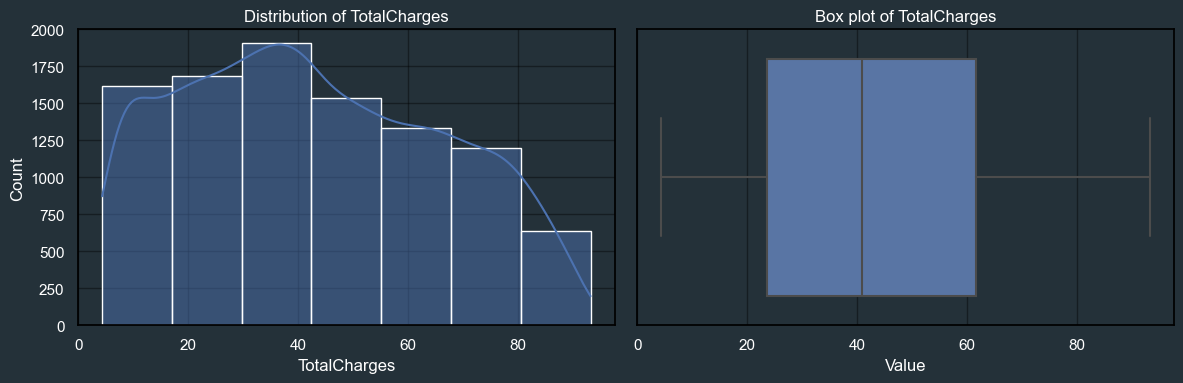

In [274]:
numerical_distribution(df, 'TotalCharges')

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Feature Scaling</p>

In [275]:
Scaler = StandardScaler()
df[numerical_cols] = Scaler.fit_transform(df[numerical_cols])

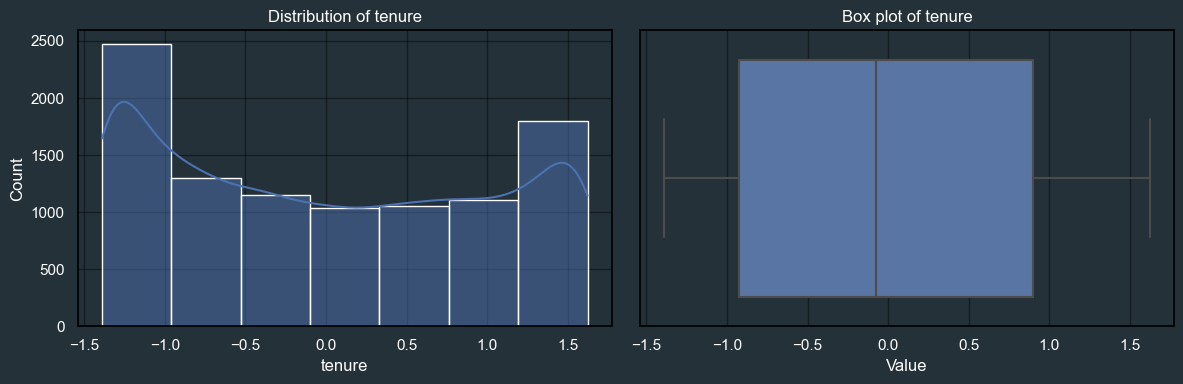

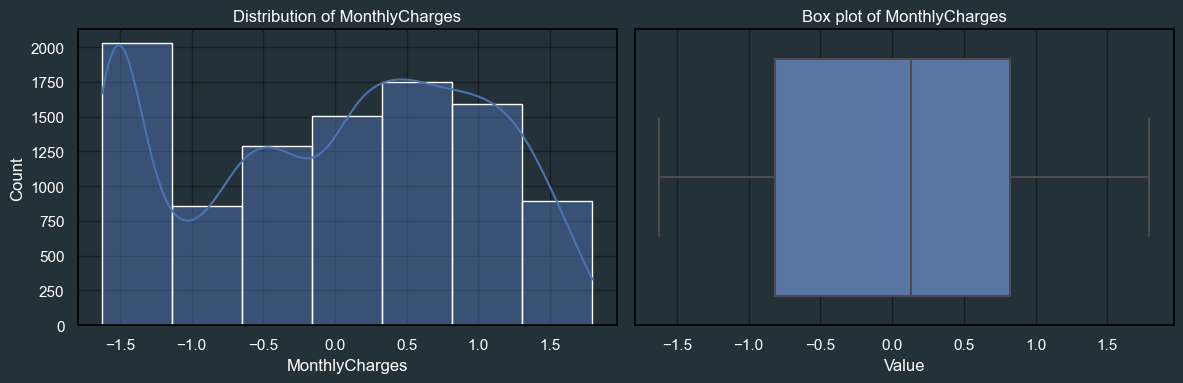

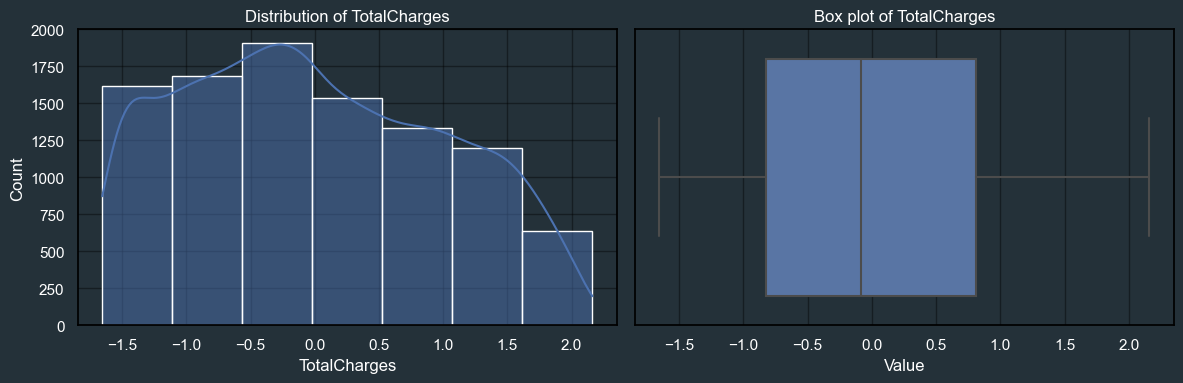

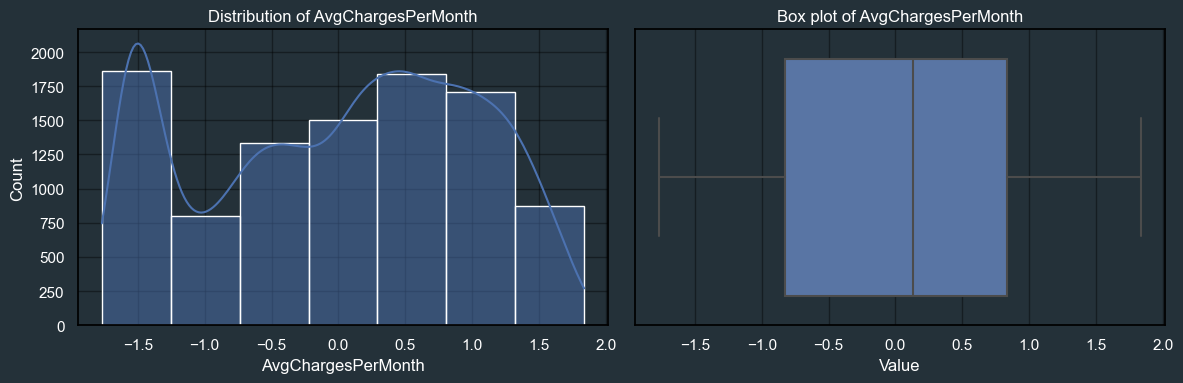

In [276]:
for i in numerical_cols:
  numerical_distribution(df, i)

In [277]:
joblib.dump(Scaler, 'scaler.pkl')

['scaler.pkl']

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Encoding</p>

In [278]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # Ensure all data is string (safe for categories)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [279]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgChargesPerMonth,TenureCategory,TotalServicesSubscribed
0,7590-VHVEG,0,0,1,0,-1.388785,0,1,0,0,...,0,0,1,4,-1.233074,-1.605716,0,-1.230143,2,1
1,5575-GNVDE,1,0,0,0,0.010511,1,0,0,2,...,0,1,0,5,-0.322740,0.026155,0,-0.368121,1,3
2,3668-QPYBK,1,0,0,0,-1.346382,1,0,0,2,...,0,0,1,5,-0.426874,-1.393772,1,-0.418338,2,3
3,7795-CFOCW,1,0,0,0,0.476943,0,1,0,2,...,0,1,0,1,-0.814858,0.001920,0,-0.859660,1,3
4,9237-HQITU,0,0,0,0,-1.346382,1,0,1,0,...,0,0,1,4,0.139145,-1.311540,1,0.310526,2,1


In [285]:
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Interactive Dashboard</p>

In [281]:
import dash
from dash import dcc, html, Input, Output, State, dash_table
import plotly.express as px
import pandas as pd
from functools import lru_cache

# Assuming df is provided; strip column names
df.columns = df.columns.str.strip()

# Debug: Print unique values to diagnose data issues
print("DataFrame columns:", df.columns)
print("InternetService values:", df['InternetService'].unique())
print("Churn values:", df['Churn'].unique())

# Custom dark theme layout
custom_dark_layout = dict(
    plot_bgcolor="#1F2A44",
    paper_bgcolor="#1F2A44",
    font=dict(family="Inter, Arial, sans-serif", color="#E6E6FA", size=12),
    xaxis=dict(
        showgrid=True,
        gridcolor="#2F3B5C",
        gridwidth=1,
        linecolor="#2F3B5C",
        tickfont=dict(color="#E6E6FA"),
        titlefont=dict(color="#E6E6FA"),
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="#2F3B5C",
        gridwidth=1,
        linecolor="#2F3B5C",
        tickfont=dict(color="#E6E6FA"),
        titlefont=dict(color="#E6E6FA"),
    ),
    legend=dict(
        font=dict(color="#E6E6FA"),
        bgcolor="rgba(31, 42, 68, 0.8)",
        bordercolor="#2F3B5C",
        borderwidth=1,
    ),
    margin=dict(l=40, r=40, t=60, b=40),
    hoverlabel=dict(
        bgcolor="#2F3B5C",
        font_size=12,
        font_family="Inter"
    )
)


DataFrame columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'AvgChargesPerMonth', 'TenureCategory', 'TotalServicesSubscribed'],
      dtype='object')
InternetService values: [0 1 2]
Churn values: [0 1]


In [282]:
@lru_cache(maxsize=32)
def get_filtered_df(contract_types_tuple):
    contract_types = list(contract_types_tuple)
    return df[df['Contract'].isin(contract_types)]

app = dash.Dash(__name__)
app.title = "Customer Churn Analytics"

app.layout = html.Div(
    style={
        'backgroundColor': '#141C33',
        'color': '#E6E6FA',
        'fontFamily': 'Inter, Arial, sans-serif',
        'padding': '20px',
        'minHeight': '100vh'
    },
    children=[
        html.H1(
            "Customer Churn Analytics",
            style={
                'textAlign': 'center',
                'color': '#FFFFFF',
                'fontSize': '36px',
                'marginBottom': '30px',
                'fontWeight': '600'
            }
        ),

        # Control Panel
        html.Div([
            html.Label(
                "Filter by Contract Type",
                style={'fontSize': '16px', 'fontWeight': '600', 'marginBottom': '10px'}
            ),
            dcc.Dropdown(
                id='contract_filter',
                options=[{'label': c, 'value': c} for c in sorted(df['Contract'].unique())],
                value=list(df['Contract'].unique()),
                multi=True,
                clearable=False,
                style={
                    'backgroundColor': '#2F3B5C',
                    'color': '#141C33',
                    'borderRadius': '5px'
                }
            ),
            html.Button(
                'Reset Filters',
                id='reset_button',
                n_clicks=0,
                style={
                    'marginTop': '10px',
                    'backgroundColor': '#4682B4',
                    'color': '#FFFFFF',
                    'border': 'none',
                    'padding': '8px 16px',
                    'borderRadius': '5px',
                    'cursor': 'pointer'
                }
            )
        ], style={
            'width': '50%',
            'margin': '0 auto 30px',
            'padding': '20px',
            'backgroundColor': '#1F2A44',
            'borderRadius': '8px',
            'boxShadow': '0 2px 4px rgba(0,0,0,0.2)'
        }),

        dcc.Tabs([
            dcc.Tab(
                label='Exploratory Data Analysis',
                style={'backgroundColor': '#1F2A44', 'color': '#E6E6FA'},
                selected_style={'backgroundColor': '#4682B4', 'color': '#FFFFFF'},
                children=[
                    html.Div([
                        html.Div([
                            dcc.Graph(
                                id='churn_pie_chart',
                                style={'width': '48%', 'display': 'inline-block'}
                            ),
                            dcc.Graph(
                                id='tenure_vs_charges',
                                style={'width': '48%', 'display': 'inline-block'}
                            ),
                        ], style={'textAlign': 'center', 'marginBottom': '20px'}),
                        html.Div([
                            dcc.Graph(id='churn_by_internet', style={'width': '98%'}),
                        ], style={'textAlign': 'center', 'marginBottom': '20px'}),
                        dcc.Graph(id='charges_distribution', style={'width': '98%'}),
                    ], style={'padding': '20px'})
                ]
            ),

            dcc.Tab(
                label='Customer Insights',
                style={'backgroundColor': '#1F2A44', 'color': '#E6E6FA'},
                selected_style={'backgroundColor': '#4682B4', 'color': '#FFFFFF'},
                children=[
                    html.Div([
                        html.Label(
                            "Search by Customer ID",
                            style={'fontSize': '16px', 'fontWeight': '600', 'marginBottom': '10px'}
                        ),
                        dcc.Input(
                            id='customer_id_input',
                            type='text',
                            placeholder='Enter customer ID (e.g., 1234-ABCDE)',
                            style={
                                'width': '30%',
                                'padding': '8px',
                                'backgroundColor': '#2F3B5C',
                                'color': '#E6E6FA',
                                'border': 'none',
                                'borderRadius': '5px',
                                'marginRight': '10px'
                            }
                        ),
                        html.Button(
                            'Search',
                            id='search_button',
                            n_clicks=0,
                            style={
                                'backgroundColor': '#4682B4',
                                'color': '#FFFFFF',
                                'border': 'none',
                                'padding': '8px 16px',
                                'borderRadius': '5px',
                                'cursor': 'pointer'
                            }
                        ),
                    ], style={'textAlign': 'center', 'margin': '30px'}),
                    html.Div(id='customer_details', style={'textAlign': 'center', 'marginTop': '20px'})
                ]
            ),

            dcc.Tab(
                label='Data Table',
                style={'backgroundColor': '#1F2A44', 'color': '#E6E6FA'},
                selected_style={'backgroundColor': '#4682B4', 'color': '#FFFFFF'},
                children=[
                    dash_table.DataTable(
                        id='data_table',
                        columns=[{'name': col, 'id': col} for col in df.columns],
                        data=df.to_dict('records'),
                        style_table={
                            'height': '500px',
                            'overflowY': 'auto',
                            'backgroundColor': '#1F2A44',
                            'borderRadius': '8px'
                        },
                        style_cell={
                            'textAlign': 'center',
                            'backgroundColor': '#1F2A44',
                            'color': '#E6E6FA',
                            'padding': '8px',
                            'fontSize': '14px'
                        },
                        style_header={
                            'backgroundColor': '#2F3B5C',
                            'fontWeight': 'bold',
                            'color': '#E6E6FA'
                        },
                        filter_action='native',
                        page_size=15,
                        export_format='csv',
                        export_headers='display'
                    )
                ]
            )
        ])
    ]
)


In [283]:
@app.callback(
    Output('contract_filter', 'value'),
    Input('reset_button', 'n_clicks')
)
def reset_filters(n_clicks):
    return list(df['Contract'].unique())

@app.callback(
    Output('churn_pie_chart', 'figure'),
    Input('contract_filter', 'value')
)
def update_pie_chart(contract_types):
    if not contract_types:
        return px.pie(title="No contract types selected", template="plotly_dark")
    filtered_df = get_filtered_df(tuple(contract_types))
    fig = px.pie(
        filtered_df,
        names='Churn',
        title='Churn Distribution by Contract Type',
        color_discrete_sequence=px.colors.qualitative.Bold,
        hole=0.4
    )
    fig.update_traces(
        textinfo='percent+label',
        pull=[0.1, 0],
        hovertemplate='%{label}: %{value} (%{percent})'
    )
    fig.update_layout(
        custom_dark_layout,
        title_x=0.5,
        showlegend=True
    )
    return fig

@app.callback(
    Output('tenure_vs_charges', 'figure'),
    Input('contract_filter', 'value')
)
def update_scatter_plot(contract_types):
    if not contract_types:
        fig = px.scatter(
            title="No Contract Types Selected",
            template="plotly_dark"
        )
        fig.update_layout(
            custom_dark_layout,
            title_x=0.5,
            showlegend=False
        )
        return fig
    filtered_df = get_filtered_df(tuple(contract_types))
    fig = px.scatter(
        filtered_df,
        x='tenure',
        y='MonthlyCharges',
        color='Churn',
        title='Tenure vs Monthly Charges',
        labels={'tenure': 'Tenure (Months)', 'MonthlyCharges': 'Monthly Charges ($)'},
        color_discrete_sequence=px.colors.qualitative.Vivid,
        hover_data=['customerID', 'InternetService', 'PaymentMethod'],
        opacity=0.7
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=1, color='#1F2A44')))
    fig.update_layout(custom_dark_layout, title_x=0.5)
    return fig

@app.callback(
    Output('churn_by_internet', 'figure'),
    Input('contract_filter', 'value')
)
def update_churn_by_internet(contract_types):
    if not contract_types:
        return px.bar(title="No contract types selected", template="plotly_dark")
    filtered_df = get_filtered_df(tuple(contract_types))
    grouped = filtered_df.groupby(['InternetService', 'Churn']).size().reset_index(name='Count')
    fig = px.bar(
        grouped,
        x='InternetService',
        y='Count',
        color='Churn',
        barmode='group',
        title='Churn by Internet Service Type',
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    fig.update_traces(hovertemplate='Service: %{x}<br>Churn: %{customdata}<br>Count: %{y}')
    fig.update_layout(custom_dark_layout, title_x=0.5)
    return fig

@app.callback(
    Output('charges_distribution', 'figure'),
    Input('contract_filter', 'value')
)
def update_histogram(contract_types):
    if not contract_types:
        return px.histogram(title="No contract types selected", template="plotly_dark")
    filtered_df = get_filtered_df(tuple(contract_types))
    fig = px.histogram(
        filtered_df,
        x='MonthlyCharges',
        color='Churn',
        title='Monthly Charges Distribution',
        color_discrete_sequence=px.colors.qualitative.Set3,
        nbins=30
    )
    fig.update_traces(
        hovertemplate='Charges: $%{x:.2f}<br>Churn: %{customdata}<br>Count: %{y}'
    )
    fig.update_layout(
        custom_dark_layout,
        title_x=0.5,
        barmode='overlay',
        bargap=0.1
    )
    return fig

@app.callback(
    Output('customer_details', 'children'),
    Input('search_button', 'n_clicks'),
    State('customer_id_input', 'value')
)
def update_customer_details(n_clicks, customer_id):
    if n_clicks == 0 or not customer_id:
        return html.Div()
    
    # Basic input validation
    customer_id = customer_id.strip()
    if not customer_id:
        return html.Div(
            html.P("Please enter a valid Customer ID.", style={'color': '#FF6B6B'}),
            style={'padding': '20px'}
        )
    
    customer_data = df[df['customerID'] == customer_id]
    if not customer_data.empty:
        churn = customer_data['Churn'].values[0]
        tenure = customer_data['tenure'].values[0]
        monthly_charges = customer_data['MonthlyCharges'].values[0]
        total_charges = customer_data['TotalCharges'].values[0]
        contract = customer_data['Contract'].values[0]
        internet = customer_data['InternetService'].values[0]
        
        return html.Div([
            html.H3(f"Customer ID: {customer_id}", style={'color': '#4682B4'}),
            html.P(f"Churn Status: {churn}", style={'fontSize': '16px'}),
            html.P(f"Tenure: {tenure} months", style={'fontSize': '16px'}),
            html.P(f"Monthly Charges: ${monthly_charges:.2f}", style={'fontSize': '16px'}),
            html.P(f"Total Charges: ${total_charges:.2f}", style={'fontSize': '16px'}),
            html.P(f"Contract Type: {contract}", style={'fontSize': '16px'}),
            html.P(f"Internet Service: {internet}", style={'fontSize': '16px'})
        ], style={
            'backgroundColor': '#1F2A44',
            'padding': '20px',
            'borderRadius': '8px',
            'margin': '0 auto',
            'width': '50%',
            'boxShadow': '0 2px 4px rgba(0,0,0,0.2)'
        })
    else:
        return html.Div(
            html.P(f"Customer ID '{customer_id}' not found.", style={'color': '#FF6B6B'}),
            style={'padding': '20px'}
        )

if __name__ == '__main__':
    app.run_server(debug=True)

In [284]:
df.to_csv("Data/Preprocessed Dataset.csv", index= False)